## Import SAS & Open Source Packages
Postprocessing done in SAS Micro Analytics Services.

In [1]:
#Import Open Source packages
import threading
import time
import websocket
import json
import numpy as np
import base64
import cv2
#Import SAS Packages
import esppy
from esppy.espapi.visuals import Visuals

## Build SAS Event Stream Processing Pipeline

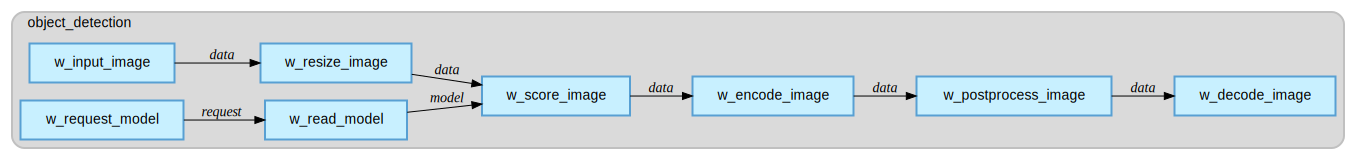

In [2]:
#Helpfer Function:
def window_fields(number_objects, func):
    if func == 'score':
        _field = "id*:int64,image:blob,_image_:blob,_nObjects_:double,"
    if func == 'encode':
        _field = "id*:int64,image:string,_nObjects_:double,"
    for obj in range(0,number_objects):
        _field += "_Object" + str(obj) + "_:string,"
        _field += "_P_Object" + str(obj) + "_:double,"
        _field += "_Object" + str(obj) + "_x:double,"
        _field += "_Object" + str(obj) + "_y:double,"
        _field += "_Object" + str(obj) + "_width:double,"
        _field += "_Object" + str(obj) + "_height:double,"
    return _field[:-1]

#Connect to ESP and create ESP project
esp = esppy.ESP(hostname='http://localhost:9900')
esp_project = esp.create_project('object_detection', n_threads=10)
esp_project.pubsub = 'manual'
esp_project.add_continuous_query('contquery')

# Window: Video Capture
vid_capture = esp.SourceWindow(schema=('id*:int64', 'image:blob'),
index_type='empty', insert_only=True)
vid_capture.pubsub = True
esp_project.windows['w_input_image'] = vid_capture

# Window: Video Resize
vid_capture_resize = esp.CalculateWindow(algorithm='ImageProcessing', 
                                         name='resized', 
                                         function='resize',
                                         height=416, 
                                         width=416, 
                                         input_map=dict(imageInput='image'), 
                                         output_map=dict(imageOutput='_image_'))
vid_capture_resize.schema_string = 'id*:int64,image:blob,_image_:blob'
esp_project.windows['w_resize_image'] = vid_capture_resize

# Window: Model Reader
model_reader = esp.ModelReaderWindow()
esp_project.windows['w_read_model'] = model_reader

# Window: Model Request
model_request = esp.SourceWindow(schema=('req_id*:int64', 'req_key:string', 'req_val:string'),index_type='empty', insert_only=True)
esp_project.windows['w_request_model'] = model_request

# Window: Model Score
model_score = esp.ScoreWindow(schema=window_fields(20, 'score'))
#model_score.pubsub = True
model_score.add_offline_model(model_type='astore')
#model_score.schema_string = window_fields(20, 'score')
esp_project.windows['w_score_image'] = model_score

# Window: Encode Binary Image to Text for Python
func1 = esp.FunctionalWindow(schema=window_fields(20, 'encode'), 
                            index_type='empty')
func1.set_function_context_functions(image='base64EncodeBinary($image)')
esp_project.windows['w_encode_image'] = func1

# Window: Postrocessing in Python
wpython = esp.PythonHelper(schema=('id*:int64', '_image_scored_:string'), 
                           index_type='empty',name='w_python')
wpython.add_mas_info('module_1', 'postprocess_image', 'w_encode_image', code_file='./image_postprocessing.py')
esp_project.windows['w_postprocess_image'] = wpython

# Window: Encode Image String to Binary
func2 = esp.FunctionalWindow(schema=('id*:int64', '_image_scored_:blob'), 
                             index_type='empty', 
                             name='w_func2', 
                             pubsub=True)
func2.set_function_context_functions(_image_scored_='base64DecodeBinary($_image_scored_)')
esp_project.windows['w_decode_image'] = func2

# Connections
vid_capture.add_target(vid_capture_resize, role='data')
vid_capture_resize.add_target(model_score, role='data')
model_request.add_target(model_reader, role='request')
model_reader.add_target(model_score, role='model')
model_score.add_target(func1, role='data')
func1.add_target(wpython, role='data')
wpython.add_target(func2, role='data')

# Load Project
esp.load_project(esp_project)

# Publisher: Send Model to Scoring Window
pub = model_request.create_publisher(blocksize=1, rate=0, pause=0, dateformat='%Y%dT%H:%M:%S.%f', opcode='insert', format='csv')
pub.send('i,n,1,"usegpuesp","1"\n')
pub.send('i,n,2,"ndevices","1"\n')
pub.send('i,n,3,"action","load"\n')
pub.send('i,n,4,"type","astore"\n')
pub.send('i,n,5,"reference","/data/notebooks/deep_learning_examples/models/object_detection/tiny_yolov2_313cls/Tiny-Yolov2.astore"\n')
pub.send('i,n,6,,\n')
pub.close()

# Publisher: Send Video
esp_pub = vid_capture.create_publisher(blocksize=1, rate=0, pause=0, opcode='insert', format='csv')

# Display project
esppy.options.display.image_scale = 0.8
esp_project

## Define Video-Publisher

In [3]:
# Class to publish videos from camera to ESP
class video_pub():
    def __init__(self, pub, fps):
        self.cap = cv2.VideoCapture(0)
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        self.cap.set(cv2.CAP_PROP_FOURCC, fourcc)
        self.cap.set(3,1280)
        self.cap.set(4,720)
        self.pub = pub
        self.FPS = fps
        threading.Thread(target=self.stream, daemon=True).start()
        print('Publisher started!')
        
    def stream(self):
        prev = 0
        while True:
            time_elapsed = time.time() - prev
            if time_elapsed > 1./self.FPS:
                prev = time.time()
                ret, frame = self.cap.read()
                frame = cv2.flip(frame, 1)
                _, buffer = cv2.imencode('.jpg', frame)
                encoded_string = base64.b64encode(buffer)
                strToSend = 'i, n, ' + str(int(time.time()*100)) + ',' + encoded_string.decode() + ',' + '\n'
                self.pub.send(strToSend)

## Define Video-Subscriber to obtain scored images

In [4]:
#Class to subscribe to ESP to receive and highlight scored images
class video_sub():
    def __init__(self):
        self.ws = websocket.WebSocketApp("ws://localhost:9900/SASESP/subscribers/object_detection/contquery/w_decode_image/?format=json&mode=streaming&pagesize=1",
                                 on_message = self.on_message,
                                 on_error = self.on_error,
                                 on_close = self.on_close)
        self.ws.on_open = self.on_open
        self.frame = None
        threading.Thread(target=self.ws.run_forever, daemon=True).start()
        print('Subscriber Started!')
        return

    def on_message(self, message):
        try:
            data = json.loads(message)
            imageBufferBase64 = data['events'][0]['event']['_image_scored_']['_image_scored_']
            nparr = np.frombuffer(base64.b64decode(imageBufferBase64), dtype=np.uint8)
            self.frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        except:
            None

    def on_error(self, error):
        print(error)

    def on_close(self):
        print("Websocket closed!")

    def on_open(self):
        print('Websocket open!')

## Start the Video-Publisher & -Subscriber

In [5]:
pub = video_pub(esp_pub, fps=25)
sub = video_sub()

Publisher started!
Subscriber Started!
Websocket open!


## Display scored images

In [6]:
#Displays scored frames
while(True):
    # Capture frame-by-frame
    frame = sub.frame

    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cv2.destroyAllWindows()